# CMB-S4 All Chile config - Neff plots

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np, glob, healpy as H, os, sys, pickle, tools
from pylab import *

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

In [3]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'
rcParams['font.family'] = 'serif'

# Read the Fisher matrices

In [40]:
survey_dic = {
             'wide': ['wide_supplement', r'LAT-Wide'],
             'roman': ['roman_supplement', r'LAT-Roman'], 
             'delensing': ['delensing_sun90bk', r'LAT-Delensing'], 
             }

expname_pref = 's4_all_chile_config'
survey_arr = ['wide', 'delensing']
patch_arr = [1, 2, 3, 4]
year_arr = np.arange(1, 10.1)


fsky_dic = {'GAL070':
                {
                    'wide': {1: 0.053918, 2: 0.217058, 3: 0.0122569, 4: 0.0207677}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                },
            'GAL080':
                {
                    'wide': {1: 0.0592472, 2: 0.257352, 3: 0.0139942, 4: 0.0238788}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                },
            'GAL090':
                {
                    'wide': {1: 0.064, 2: 0.31, 3: 0.016, 4: 0.027}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                }
           }

fsky_dic_aso = {'aso_only': 
                   {
                    'baseline': 0.4, 
                    'goal': 0.4,
                   },
                'aso_plus_s4': 
                   {
                    'baseline': 0.12, 
                    'goal': 0.12,
                   }
               }

fd = 'results/neff/phase3/'
fname = '%s/saveChileS4Fishers_fsky1.pkl' %(fd)
res_dic = pickle.load( open(fname, 'rb') )
print( res_dic.keys() )

aso_fd = 'results/neff/phase3_SO/'
aso_exp_dic = {'baseline': ['ASO-Baseline', 'royalblue'], 
               'goal': ['ASO-Goal', 'darkorange']}
aso_fname = '%s/saveChileSOFishers_fsky100_lensed.pkl' %(aso_fd)
aso_res_dic = pickle.load( open(aso_fname, 'rb') )
aso_patch = 1
aso_year = 1
print( aso_res_dic.keys() )

#params
param_names = ['omega_c_h2', 'omega_b_h2', 'N_eff', 'A_s', 'n_s', 'tau', 'theta_s']
desired_param = 'N_eff'



dict_keys(['wide', 'delensing', 'S4'])
dict_keys(['baseline', 'goal', 'S4'])


# Neff for GAL070, GAL080, and GAL090 mask
* ## Patch 1 and 2, and 
* ## all patches combined

In [41]:
reqd_gal_mask_arr = ['GAL070', 'GAL080', 'GAL090']
sigma_neff_dic = {}
sigma_neff_dic_for_aso = {}
sigma_neff_dic_for_s4_plus_aso = {}
for reqd_gal_mask in reqd_gal_mask_arr:
    sigma_neff_dic[reqd_gal_mask] = {}
    sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask] = {}
    for iter in range(2):
        sigma_neff_dic[reqd_gal_mask][iter] = {}
        sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter] = {}
        if iter == 0:
            reqd_patch_arr = [1, 2]
        else:
            reqd_patch_arr = [1, 2, 3, 4]
        fisher_dic = {}
        for survey in res_dic:
            if survey == 'S4': continue
            #print(res_dic[keyname].keys()); sys.exit()
            fisher_dic[survey] = {}
            for patch in patch_arr:
                if patch not in reqd_patch_arr: continue
                fisher_dic[survey][patch] = {}
                for year in year_arr:
                    fmat = res_dic[survey][patch][year]

                    #multiply fmat with fsky
                    curr_fsky = fsky_dic[reqd_gal_mask][survey][patch]
                    fmat = fmat * curr_fsky
                    ##print(reqd_gal_mask, iter, survey, patch, curr_fsky, fmat.shape)
                    fisher_dic[survey][patch][year] = fmat
                    
        #ASO results
        aso_fisher_dic = {}
        for aso_iter in range(2):
            aso_fisher_dic[aso_iter] = {}
            for survey in aso_res_dic:
                if survey == 'S4': continue
                aso_fisher_dic[survey] = {}
                fmat = aso_res_dic[survey][aso_patch][aso_year]

                #multiply fmat with fsky
                if aso_iter == 0:
                    curr_fsky = fsky_dic_aso['aso_only'][survey]
                elif aso_iter == 1:
                    curr_fsky = fsky_dic_aso['aso_plus_s4'][survey]
                fmat = fmat * curr_fsky
                aso_fisher_dic[aso_iter][survey] = fmat

        #------------------------------------------
        #combine Fisher matrices now

        #S4-only
        ##print('\n\ncombine Fisher matrices now\n')
        survey1, survey2 = 'wide', 'delensing'
        survey_arr_for_comb = [survey1, survey2]
        for year in year_arr:
            comb_fmat = None
            for survey in survey_arr_for_comb:
                #print(survey)
                for patch in fisher_dic[survey]:
                    #print(patch)
                    curr_fmat = fisher_dic[survey][patch][year]
                    if comb_fmat is None:
                        comb_fmat = np.copy( curr_fmat )
                    else:
                        comb_fmat += np.copy( curr_fmat )


            #get neff sigma
            curr_sigma_neff = tools.get_sigma_of_a_parameter(comb_fmat, param_names, [desired_param])
            sigma_neff_dic[reqd_gal_mask][iter][year] = curr_sigma_neff[desired_param]

        #ASO-only
        aso_expname_arr = ['baseline', 'goal']
        aso_iter = 0
        for aso_expname in aso_expname_arr:
            aso_fmat = aso_fisher_dic[aso_iter][aso_expname]
            #get neff sigma
            curr_sigma_neff = tools.get_sigma_of_a_parameter(aso_fmat, param_names, [desired_param])
            sigma_neff_dic_for_aso[aso_expname] = curr_sigma_neff[desired_param]
        
        #S4+ASO
        survey1, survey2 = 'wide', 'delensing'
        survey_arr_for_comb = [survey1, survey2]
        aso_expname_arr = ['baseline', 'goal']
        aso_iter = 1
        for aso_expname in aso_expname_arr:
            sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname] = {}
            for year in year_arr:
                comb_fmat = None
                for survey in survey_arr_for_comb:
                    #print(survey)
                    for patch in fisher_dic[survey]:
                        #print(patch)
                        curr_fmat = fisher_dic[survey][patch][year]
                        if comb_fmat is None:
                            comb_fmat = np.copy( curr_fmat )
                        else:
                            comb_fmat += np.copy( curr_fmat )
            
                #now add ASO's Fmat
                aso_fmat = aso_fisher_dic[aso_iter][aso_expname]
                comb_fmat += aso_fmat

                #get neff sigma
                curr_sigma_neff = tools.get_sigma_of_a_parameter(comb_fmat, param_names, [desired_param])
                sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname][year] = curr_sigma_neff[desired_param]        
        #------------------------------------------


0.052237745760750805
0.04588203776953843


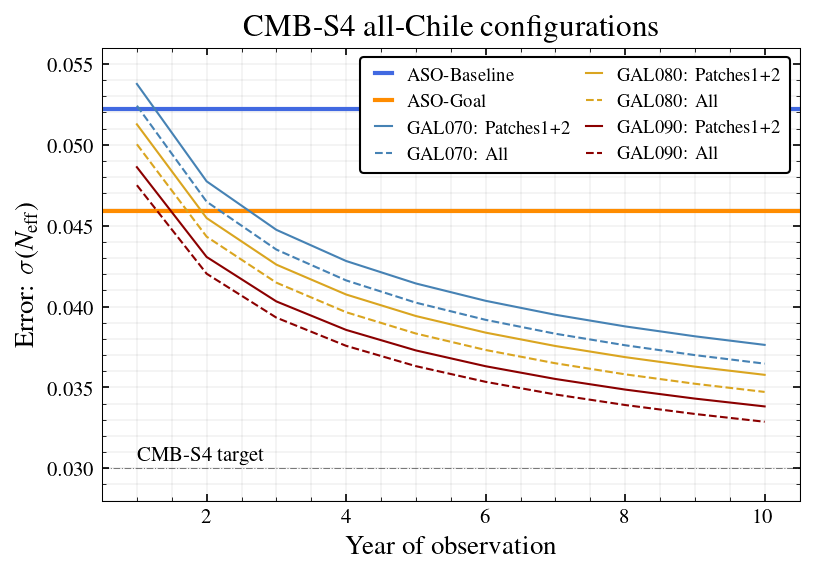

0.052237745760750805
0.04588203776953843


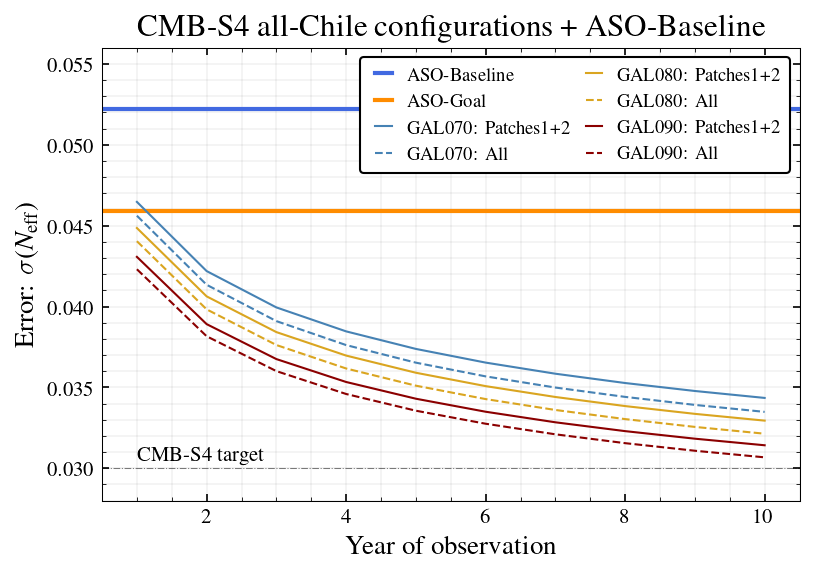

0.052237745760750805
0.04588203776953843


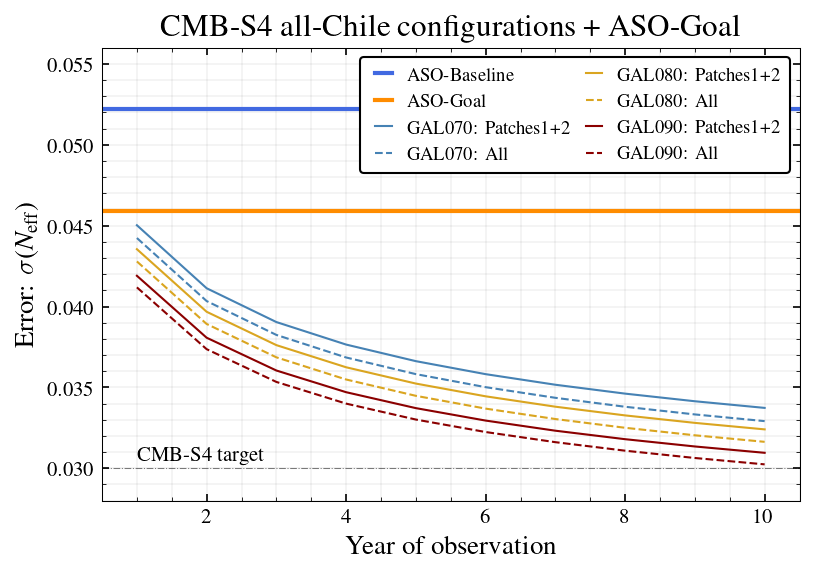

In [48]:
for pliter in range(3):
    if pliter == 0:
        plname = 'plots/sigma_neff_s4_lat_wide.png'
        title_str = r'CMB-S4 all-Chile configurations'
    elif pliter == 1:
        plname = 'plots/sigma_neff_s4_lat_wide_plus_asobaseline.png'
        aso_expname_for_this_iter = 'baseline'
        title_str = r'CMB-S4 all-Chile configurations + ASO-Baseline'
    elif pliter == 2:
        plname = 'plots/sigma_neff_s4_lat_wide_plus_asogoal.png'
        aso_expname_for_this_iter = 'goal'
        title_str = r'CMB-S4 all-Chile configurations + ASO-Goal'
    clf()
    fsval = 13
    ymin, ymax = 0.028, 0.056
    xmin, xmax = 0.5, 10.5
    color_dic = {'GAL070': 'steelblue', 'GAL080': 'goldenrod', 'GAL090': 'darkred'}
    ls_dic = {0: '-', 1: '--'}
    ax = subplot(111)

    #Add ASO-only
    for aso_expname in aso_expname_arr:
        aso_labval, aso_color = aso_exp_dic[aso_expname]
        sigma_neff_curr_aso = sigma_neff_dic_for_aso[aso_expname]
        print(sigma_neff_curr_aso)
        axhline(sigma_neff_curr_aso, lw = 2, alpha = 1., ls = '-', color = aso_color, label = r'%s' %(aso_labval))
    
    if pliter == 0:
        #S4-only
        for reqd_gal_mask in sigma_neff_dic:

            for iter in sigma_neff_dic[reqd_gal_mask]:
                if iter == 0:
                    labval = r'%s: Patches1+2' %(reqd_gal_mask)
                else:
                    labval = r'%s: All' %(reqd_gal_mask)
                sigma_neff_arr = []
                for year in sigma_neff_dic[reqd_gal_mask][iter]:
                    sigma_neff_arr.append( sigma_neff_dic[reqd_gal_mask][iter][year] )
                plot( year_arr, sigma_neff_arr, color = color_dic[reqd_gal_mask], ls = ls_dic[iter], label = labval)
    elif pliter in [1, 2]:
        #S4+ASO-Baseline or S4+ASO-Goal
        for reqd_gal_mask in sigma_neff_dic_for_s4_plus_aso:

            for iter in sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask]:
                if iter == 0:
                    labval = r'%s: Patches1+2' %(reqd_gal_mask)
                else:
                    labval = r'%s: All' %(reqd_gal_mask)
                sigma_neff_arr = []
                for year in sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname_for_this_iter]:
                    sigma_neff_arr.append( sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname_for_this_iter][year] )
                plot( year_arr, sigma_neff_arr, color = color_dic[reqd_gal_mask], ls = ls_dic[iter], label = labval)                    

    axhline(0.03, lw = 0.5, alpha = 0.5, ls = '-.')
    text(1., 0.0305, r'CMB-S4 target')
    ylim( ymin, ymax )
    xlim( xmin, xmax )
    legend(loc = 1, fontsize = fsval-4, ncol = 2, framealpha = 1., columnspacing = 0.5, handletextpad = 0.5, handlelength = 1.5)
    ylabel(r'Error: $\sigma(N_{\rm eff})$', fontsize = fsval)
    xlabel(r'Year of observation', fontsize = fsval )
    title(r'%s' %(title_str), fontsize = fsval + 2)
    grid(True, which = 'both', axis = 'both', lw = 0.2, alpha = 0.2)    
    savefig(plname, dpi = 200.)
    show()